## Recurrent Neural Network

In [2]:
import os#%pip install pandas_ta
os.environ["LD_LIB_CONFIG_PATH"] = "../configuration"
import lseg.data as ld


In [3]:
ld.open_session()

<lseg.data.session.Definition object at 0x1e96e7fdd10 {name='workspace'}>

In [2]:
import numpy as np
import pandas as pd
import cufflinks as cf  # Cufflinks
import configparser as cp
cf.set_config_file(offline=True)  # set the plotting mode to offline

import math
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, 
                                     Activation, Flatten, 
                                     MaxPooling2D, SimpleRNN)
#from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
n_steps = 13
n_features = 1

In [4]:
model = Sequential()
model.add(SimpleRNN(512, activation='relu', 
                    input_shape=(n_steps, n_features),
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

/Users/neftalivaldez/miniforge3/envs/mlf/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [5]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mse'])

In [6]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
from datetime import datetime, timedelta
today = datetime.today()
start_date = today - timedelta(days=(365*2))
stock_prices = ld.get_history(universe=['AAPL.O', 'MSFT.O'], fields=['TR.CLOSEPRICE'], interval="1D",
               start = start_date, end = today)
stock_prices.to_parquet('stock_prices.parquet.gzip',
              compression='gzip')  
pd.read_parquet('stock_prices.parquet.gzip')  

Close Price,AAPL.O,MSFT.O
Date,,
2023-05-30,177.3,331.21
2023-05-31,177.25,328.39
2023-06-01,180.09,332.58
2023-06-02,180.95,335.4
2023-06-05,179.58,335.94
...,...,...
2025-05-20,206.86,458.17
2025-05-21,202.09,452.57
2025-05-22,201.36,454.86


In [8]:
stock_prices = pd.read_parquet('stock_prices.parquet.gzip')
stock_prices

Close Price,AAPL.O,MSFT.O
Date,,
2023-05-30,177.3,331.21
2023-05-31,177.25,328.39
2023-06-01,180.09,332.58
2023-06-02,180.95,335.4
2023-06-05,179.58,335.94
...,...,...
2025-05-20,206.86,458.17
2025-05-21,202.09,452.57
2025-05-22,201.36,454.86


In [9]:
diff_stock_prices = stock_prices.diff().dropna()

In [10]:
diff_stock_prices

Close Price,AAPL.O,MSFT.O
Date,,
2023-05-31,-0.05,-2.82
2023-06-01,2.84,4.19
2023-06-02,0.86,2.82
2023-06-05,-1.37,0.54
2023-06-06,-0.37,-2.26
...,...,...
2025-05-20,-1.92,-0.7
2025-05-21,-4.77,-5.6
2025-05-22,-0.73,2.29


In [11]:
split = int(len(diff_stock_prices['AAPL.O'].values) * 0.95)
diff_train_s1 = diff_stock_prices['AAPL.O'].iloc[:split]
diff_test_s1 = diff_stock_prices['AAPL.O'].iloc[split:]
diff_train_s2 = diff_stock_prices['MSFT.O'].iloc[:split]
diff_test_s2 = diff_stock_prices['MSFT.O'].iloc[split:]

In [12]:
X_s1, y_s1 = split_sequence(diff_train_s1, n_steps)
X_s1 = X_s1.reshape((X_s1.shape[0],  X_s1.shape[1], n_features))

/var/folders/5f/5s78cfys7rxc39jwjz0314g80000gn/T/ipykernel_2644/534430054.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [13]:
#Considering y variable holds numpy array
y_tensor_s1 = tf.convert_to_tensor(y_s1, dtype=tf.int64)
X_tensor_s1 = tf.convert_to_tensor(X_s1, dtype=tf.int64) 

In [14]:
history = model.fit(X_tensor_s1, y_tensor_s1, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [15]:
history

In [16]:
start = X_s1[X_s1.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [17]:
tempList_s1 = []
for i in range(len(diff_test_s1)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s1.append(yhat)

In [18]:
tempList_s1

[array([[0.10756755]], dtype=float32),
 array([[0.93108577]], dtype=float32),
 array([[2.1472871]], dtype=float32),
 array([[0.4848405]], dtype=float32),
 array([[-2.468144]], dtype=float32),
 array([[-1.4350395]], dtype=float32),
 array([[-2.143966]], dtype=float32),
 array([[-0.7068806]], dtype=float32),
 array([[0.70668983]], dtype=float32),
 array([[-3.418641]], dtype=float32),
 array([[0.8787718]], dtype=float32),
 array([[2.0501063]], dtype=float32),
 array([[1.3933294]], dtype=float32),
 array([[0.30962875]], dtype=float32),
 array([[1.1717123]], dtype=float32),
 array([[-0.23227271]], dtype=float32),
 array([[0.09383039]], dtype=float32),
 array([[-0.5083244]], dtype=float32),
 array([[0.22697966]], dtype=float32),
 array([[1.4605724]], dtype=float32),
 array([[-0.97663486]], dtype=float32),
 array([[-0.32023865]], dtype=float32),
 array([[-0.83982396]], dtype=float32),
 array([[0.29150525]], dtype=float32),
 array([[-1.3371372]], dtype=float32)]

In [19]:
X_s2, y_s2 = split_sequence(diff_train_s2, n_steps)
X_s2 = X_s2.reshape((X_s2.shape[0],  X_s2.shape[1],
                         n_features))

/var/folders/5f/5s78cfys7rxc39jwjz0314g80000gn/T/ipykernel_2644/534430054.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [20]:
#Considering y variable holds numpy array
y_tensor_s2 = tf.convert_to_tensor(y_s2, dtype=tf.int64)
X_tensor_s2 = tf.convert_to_tensor(X_s2, dtype=tf.int64) 

In [21]:
history = model.fit(X_tensor_s2, y_tensor_s2, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [22]:
start = X_s2[X_s2.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [23]:
tempList_s2 = []
for i in range(len(diff_test_s2)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s2.append(yhat)

In [24]:
diff_test_s1, np.array(tempList_s1).flatten()

(Date
 2025-04-22     6.58
 2025-04-23     4.86
 2025-04-24     3.77
 2025-04-25     0.91
 2025-04-28     0.86
 2025-04-29     1.07
 2025-04-30     1.29
 2025-05-01     0.82
 2025-05-02    -7.97
 2025-05-05    -6.46
 2025-05-06    -0.38
 2025-05-07    -2.26
 2025-05-08     1.24
 2025-05-09     1.04
 2025-05-12    12.26
 2025-05-13     2.14
 2025-05-14     -0.6
 2025-05-15    -0.88
 2025-05-16    -0.19
 2025-05-19    -2.48
 2025-05-20    -1.92
 2025-05-21    -4.77
 2025-05-22    -0.73
 2025-05-23    -6.09
 2025-05-27     4.94
 Name: AAPL.O, dtype: Float64,
 array([ 0.10756755,  0.93108577,  2.1472871 ,  0.4848405 , -2.468144  ,
        -1.4350395 , -2.143966  , -0.7068806 ,  0.70668983, -3.418641  ,
         0.8787718 ,  2.0501063 ,  1.3933294 ,  0.30962875,  1.1717123 ,
        -0.23227271,  0.09383039, -0.5083244 ,  0.22697966,  1.4605724 ,
        -0.97663486, -0.32023865, -0.83982396,  0.29150525, -1.3371372 ],
       dtype=float32))

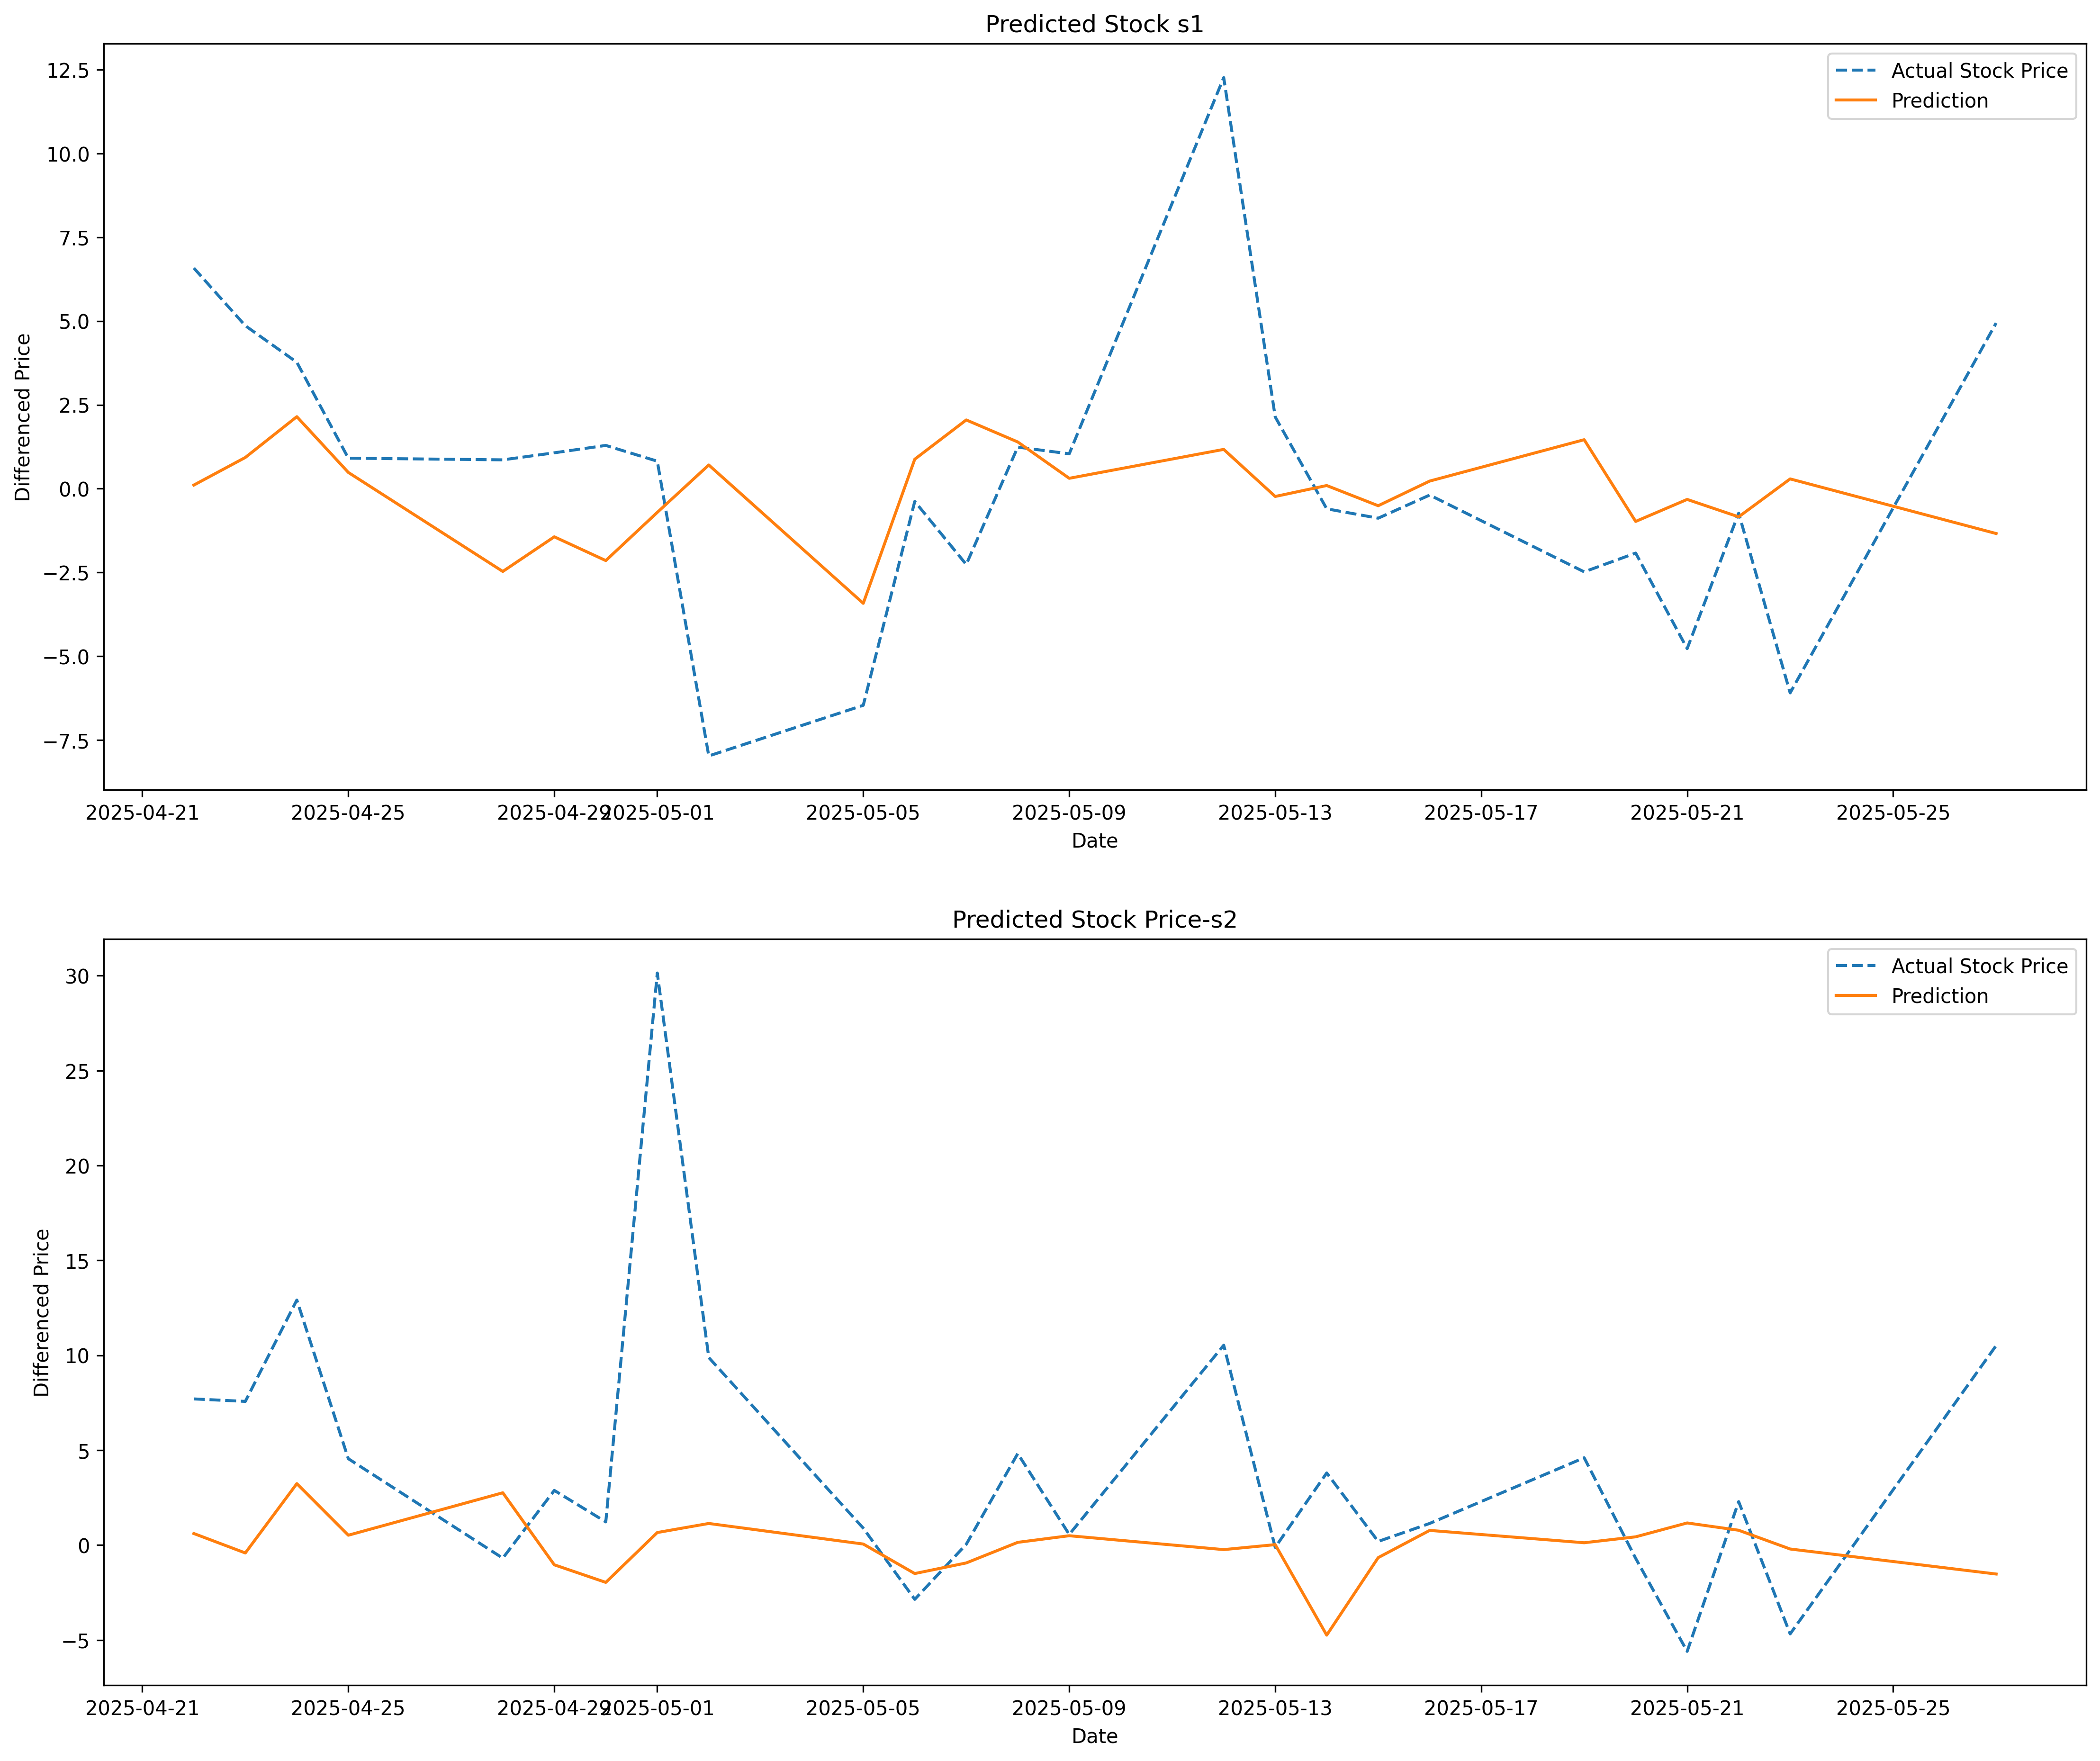

In [25]:
fig, ax = plt.subplots(2,1, figsize=(18,15))
ax[0].plot(diff_test_s1, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_s1.index, np.array(tempList_s1).flatten(),
           linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock s1')
ax[0].legend(loc='best')
ax[1].plot(diff_test_s2, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_s2.index,np.array(tempList_s2).flatten(),
           linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-s2')
ax[1].legend(loc='best')


for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='Differenced Price')
plt.show()

## LSTM

In [26]:
from tensorflow.keras.layers import LSTM


In [27]:
n_steps = 13
n_features = 1

In [28]:
model = Sequential()
model.add(LSTM(512, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

/Users/neftalivaldez/miniforge3/envs/mlf/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [29]:
model.compile(optimizer='rmsprop', loss='mean_squared_error',
              metrics=['mse'])

In [30]:
history = model.fit(X_tensor_s1, y_tensor_s1, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [31]:
start = X_s1[X_s1.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [32]:
tempList_s1 = []
for i in range(len(diff_test_s1)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s1.append(yhat)

In [ ]:
history = model.fit(X_tensor_s2, y_tensor_s2, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [ ]:
start = X_s2[X_s2.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [ ]:
tempList_s2 = []
for i in range(len(diff_test_s2)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s2.append(yhat)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(diff_test_s1, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_s1.index, np.array(tempList_s1).flatten(),
           linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-s1')
ax[0].legend(loc='best')
ax[1].plot(diff_test_s2, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_s2.index, np.array(tempList_s2).flatten(),
           linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-s2')
ax[1].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')
plt.show()